In [99]:
import os
from pathlib import Path
import re
import numpy as np
import scipy as sp
#import xlrd
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from copy import deepcopy
import pandas as pd

from pymatgen.ext.matproj import MPRester, MPRestError
from monty.serialization import loadfn, dumpfn
from pymatgen import Structure, Composition
from pymatgen.analysis.reaction_calculator import ComputedEntry, ComputedReaction
from pymatgen.util.plotting import pretty_plot, periodic_table_heatmap
from pymatgen.core import periodic_table
from pymatgen.io.vasp.outputs import Elfcar, VolumetricData

from scipy.stats import linregress, skew
from scipy.interpolate import RegularGridInterpolator
#from adjustText import adjust_text
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error

In [23]:
plt.rcParams['figure.figsize'] = [8, 6]

In [2]:
PROJECT = 'SCAN project'
workdir = Path(re.sub("(?<={})[\w\W]*".format(PROJECT), "", str(Path.cwd())))
os.chdir(workdir)
retrieval_dir = workdir / 'vasp_files' / 'elf'
retrieval_dir

PosixPath('/mnt/c/Users/Ayush/Desktop/elf-analysis/vasp_files/elf')

In [3]:
elfcar_dict = {}
for file in retrieval_dir.iterdir():
    elfcar = Elfcar.from_file(str(file))
    elfcar_dict[elfcar.structure.composition.reduced_formula] = elfcar
elfcar_dict

{'Al2S3': <pymatgen.io.vasp.outputs.Elfcar at 0x7fbc0eb9d9d0>,
 'Eu2O3': <pymatgen.io.vasp.outputs.Elfcar at 0x7fbc0e1fb370>,
 'Fe2O3': <pymatgen.io.vasp.outputs.Elfcar at 0x7fbc507c5e50>,
 'IrO2': <pymatgen.io.vasp.outputs.Elfcar at 0x7fbc507c5250>,
 'K2Si4O9': <pymatgen.io.vasp.outputs.Elfcar at 0x7fbc507c9520>,
 'MgSO4': <pymatgen.io.vasp.outputs.Elfcar at 0x7fbc507c9040>,
 'Mn3O4': <pymatgen.io.vasp.outputs.Elfcar at 0x7fbc0dd532e0>,
 'MnBr2': <pymatgen.io.vasp.outputs.Elfcar at 0x7fbc0dd4b820>,
 'Pt5Se4': <pymatgen.io.vasp.outputs.Elfcar at 0x7fbc0dd505e0>,
 'TaN': <pymatgen.io.vasp.outputs.Elfcar at 0x7fbc0dd5f160>,
 'TiC': <pymatgen.io.vasp.outputs.Elfcar at 0x7fbc0dd50940>,
 'TiO2': <pymatgen.io.vasp.outputs.Elfcar at 0x7fbc0dd58700>}

In [131]:
class EnhancedVD(VolumetricData):
    
    def __init__(self, structure, data, distance_matrix=None, data_aug=None):
        super().__init__(structure, data, distance_matrix, data_aug)

        self.xpoints = np.linspace(0.0, 1.0, num=self.dim[0])
        self.ypoints = np.linspace(0.0, 1.0, num=self.dim[1])
        self.zpoints = np.linspace(0.0, 1.0, num=self.dim[2])
        
        self.interpolator = RegularGridInterpolator((self.xpoints, self.ypoints, self.zpoints), self.data['total'], bounds_error=True)
    
    def val_at(self, x, y, z):
        #assert min(x, y, z) >= 0.0 and max(x, y, z) <= 1.0 #Don't need if bounds_error=True on self.interpolator
        result, interp = self._interpolate(x, y, z)
        if interp:
            # Raise some warning?
            pass
        return result
        
    def _interpolate(self, x, y, z):
        interpolation_used = not (x in self.xpoints and y in self.ypoints and z in self.zpoints)
        return self.interpolator([x, y, z])[0], interpolation_used
    
    def linear_slice(self, p1, p2, n=100):
        assert type(p1) in [list, np.ndarray] and type(p2) in [list, np.ndarray]
        assert len(p1) == 3 and len(p2) == 3
        xpts = np.linspace(p1[0], p2[0], num=n)
        ypts = np.linspace(p1[1], p2[1], num=n)
        zpts = np.linspace(p1[2], p2[2], num=n)
        return [self._interpolate(xpts[i], ypts[i], zpts[i])[0] for i in range(n)]

In [17]:
class NewElfcar(EnhancedVD):
    
    def __init__(self, poscar, data):
        super().__init__(poscar.structure, data)
        #self.data = data

    @classmethod
    def from_file(cls, filename):
        (poscar, data, data_aug) = VolumetricData.parse_file(filename)
        return cls(poscar, data)
    
    @classmethod
    def from_old_elfcar(cls, elfcar):                
        return cls(elfcar, elfcar.data)

    def get_alpha(self):
        alpha_data = {}
        for k, v in self.data.items():
            alpha = 1 / v
            alpha = alpha - 1
            alpha = np.sqrt(alpha)
            alpha_data[k] = alpha
        return VolumetricData(self.structure, alpha_data)
    

In [18]:
new_dict = {}
for k in elfcar_dict.keys():
    new_dict[k] = NewElfcar.from_old_elfcar(elfcar_dict[k])

In [19]:
new_dict

{'Al2S3': <__main__.NewElfcar at 0x7fbc50763610>,
 'Eu2O3': <__main__.NewElfcar at 0x7fbc0b6fed90>,
 'Fe2O3': <__main__.NewElfcar at 0x7fbc0b6fe7f0>,
 'IrO2': <__main__.NewElfcar at 0x7fbc0b6fe250>,
 'K2Si4O9': <__main__.NewElfcar at 0x7fbc0b6fe2b0>,
 'MgSO4': <__main__.NewElfcar at 0x7fbc0b6fe100>,
 'Mn3O4': <__main__.NewElfcar at 0x7fbc0b6fe640>,
 'MnBr2': <__main__.NewElfcar at 0x7fbc0b6fe190>,
 'Pt5Se4': <__main__.NewElfcar at 0x7fbc0b6fe610>,
 'TaN': <__main__.NewElfcar at 0x7fbc0b6fee50>,
 'TiC': <__main__.NewElfcar at 0x7fbc0b6fec10>,
 'TiO2': <__main__.NewElfcar at 0x7fbc0b6feca0>}

In [81]:
bond_dict = {}

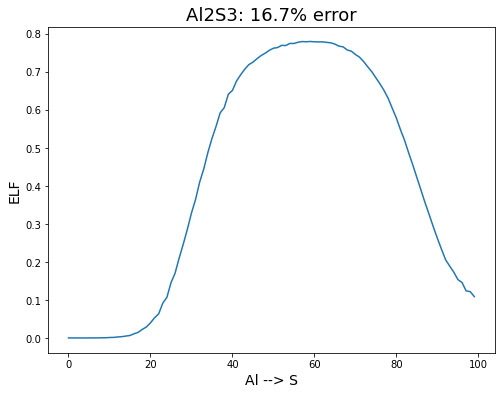

In [82]:
# Al2S3
'''
Bond: l(Al8-S10) =  2.32335(0) Å
   8     Al8 Al  0.15014  0.46005  0.62040 ( 0, 0, 0)+ x, y, z
  26     S10  S  0.39088  0.70092  0.37205 ( 0, 0, 0)+ x, y, z
'''
al2s3_bond = new_dict['Al2S3'].linear_slice([0.15014,  0.46005,  0.62040], [0.39088,  0.70092,  0.37205])
bond_dict['Al2S3'] = al2s3_bond
plt.plot(al2s3_bond)
plt.title('Al2S3: 16.7% error', fontsize=18)
plt.xlabel('Al --> S', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/Al2S3', dpi=300)
plt.show()

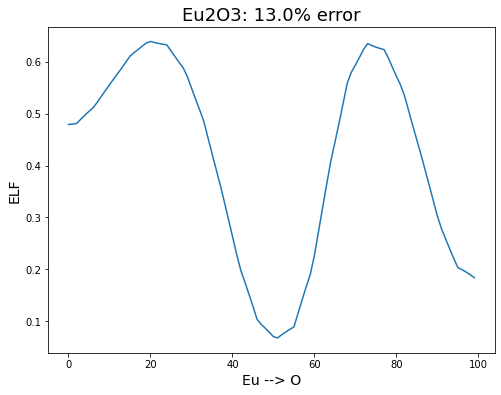

In [83]:
# Eu2O3
'''
Bond: l(Eu1-O8) =  2.34992(0) Å
   1     Eu1 Eu  0.49906  0.49869  0.49863 ( 0, 0, 0)+ x, y, z
  24      O8  O  0.22977  0.46281  0.46788 ( 0, 0, 0)+ x, y, z
'''
eu2o3_bond = new_dict['Eu2O3'].linear_slice([0.49906,  0.49869,  0.49863], [0.22977,  0.46281,  0.46788])
bond_dict['Eu2O3'] = eu2o3_bond
plt.plot(eu2o3_bond)
plt.title('Eu2O3: 13.0% error', fontsize=18)
plt.xlabel('Eu --> O', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/Eu2O3', dpi=300)
plt.show()

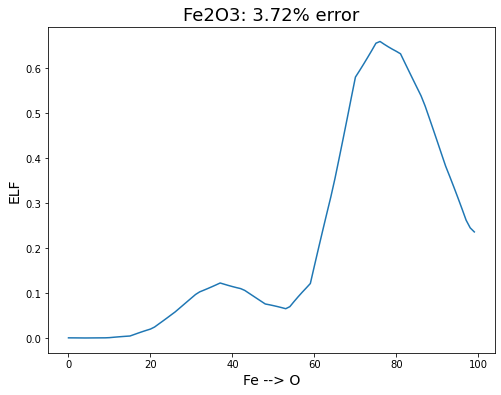

In [87]:
# Fe2O3
'''
Bond: l(Fe2-O22) =  1.95244(0) Å
   2     Fe2 Fe  0.46750  0.75193  0.21811 ( 0, 0, 0)+ x, y, z
  38     O22  O  0.72883  0.73514  0.27602 ( 0, 0, 0)+ x, y, z
'''
fe2o3_bond = new_dict['Fe2O3'].linear_slice([0.46750,  0.75193,  0.21811], [0.72883,  0.73514,  0.27602])
bond_dict['Fe2O3'] = fe2o3_bond
plt.plot(fe2o3_bond)
plt.title('Fe2O3: 3.72% error', fontsize=18)
plt.xlabel('Fe --> O', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/Fe2O3', dpi=300)
plt.show()

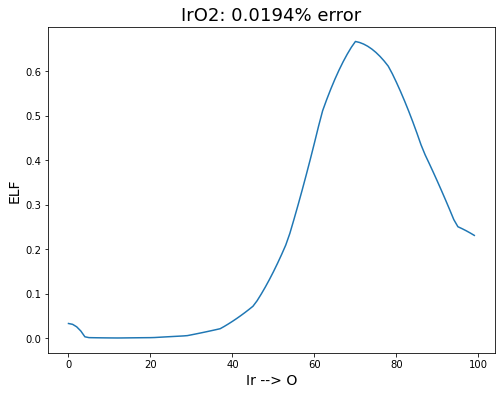

In [88]:
# IrO2
'''
Bond: l(Ir1-O4) =  1.96065(0) Å
   1     Ir1 Ir  0.50000  0.50000  0.50000 ( 0, 0, 0)+ x, y, z
   6      O4  O  0.50000  0.19156  0.80844 ( 0, 0, 0)+ x, y, z
'''
iro2_bond = new_dict['IrO2'].linear_slice([0.50000,  0.50000,  0.50000], [0.50000,  0.19156,  0.80844])
bond_dict['IrO2'] = iro2_bond
plt.plot(iro2_bond)
plt.title('IrO2: 0.0194% error', fontsize=18)
plt.xlabel('Ir --> O', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/IrO2', dpi=300)
plt.show()

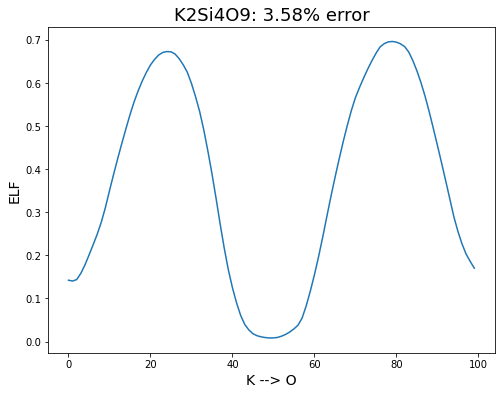

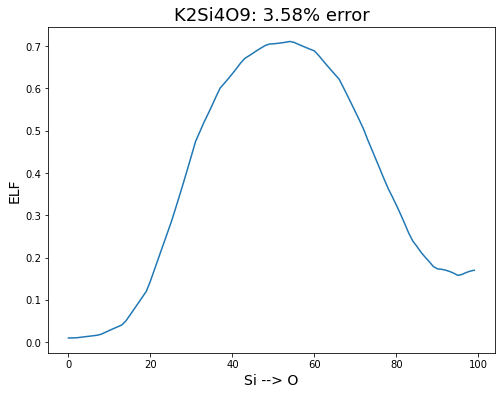

In [89]:
# K2Si4O9
'''
Bond: l(K4-O17) =  2.97395(0) Å
   4      K4  K  0.33333  0.66667  0.05739 ( 0, 0, 0)+ x, y, z
  29     O17  O  0.58243  0.50940  0.25000 ( 0, 0, 0)+ x, y, z
'''
k2si4o9_bond_ko = new_dict['K2Si4O9'].linear_slice([0.33333,  0.66667,  0.05739], [0.58243,  0.50940,  0.25000])
bond_dict['K2Si4O9-KO'] = k2si4o9_bond_ko
plt.plot(k2si4o9_bond_ko)
plt.title('K2Si4O9: 3.58% error', fontsize=18)
plt.xlabel('K --> O', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/K2Si4O9_K-O', dpi=300)
plt.show()
'''
Bond: l(Si2-O17) =  1.64367(0) Å
   6     Si2 Si  0.86949  0.63521  0.25000 ( 0, 0, 0)+ x, y, z
  29     O17  O  0.58243  0.50940  0.25000 ( 0, 0, 0)+ x, y, z
'''
k2si4o9_bond_sio = new_dict['K2Si4O9'].linear_slice([0.86949,  0.63521,  0.25000], [0.58243,  0.50940,  0.25000])
bond_dict['K2Si4O9-SiO'] = k2si4o9_bond_sio
plt.plot(k2si4o9_bond_sio)
plt.title('K2Si4O9: 3.58% error', fontsize=18)
plt.xlabel('Si --> O', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/K2Si4O9_Si-O', dpi=300)
plt.show()

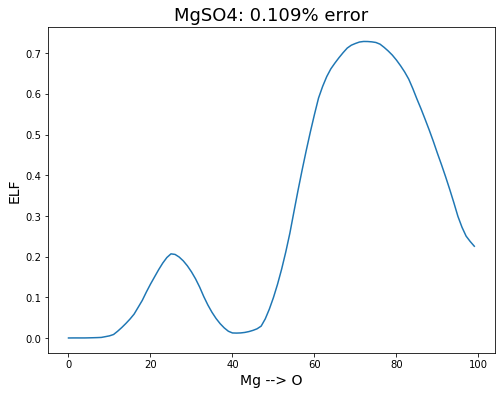

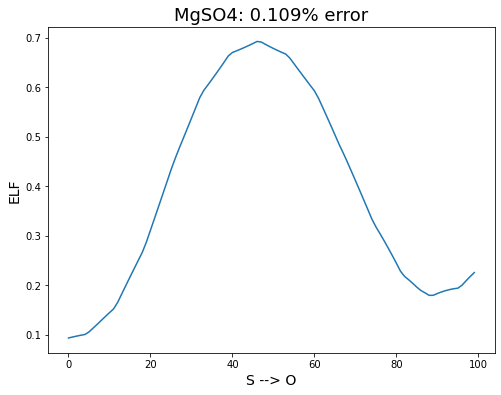

In [90]:
# MgSO4
'''
Bond: l(Mg2-O1) =  2.13075(0) Å
   2     Mg2 Mg  0.00000  0.00000  0.50000 ( 0, 0, 0)+ x, y, z
   5      O1  O  0.22725  0.30455  0.75000 ( 0, 0, 0)+ x, y, z
'''
mgso4_bond_mgo = new_dict['MgSO4'].linear_slice([0.00000,  0.00000,  0.50000], [0.22725,  0.30455,  0.75000])
bond_dict['MgSO4-MgO'] = mgso4_bond_mgo
plt.plot(mgso4_bond_mgo)
plt.title('MgSO4: 0.109% error', fontsize=18)
plt.xlabel('Mg --> O', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/MgSO4_Mg-O', dpi=300)
plt.show()
'''
Bond: l(S1-O1) =  1.48855(0) Å
   3      S1  S  0.35049  0.64951  0.75000 ( 0, 0, 0)+ x, y, z
   5      O1  O  0.22725  0.30455  0.75000 ( 0, 0, 0)+ x, y, z
'''
mgso4_bond_so = new_dict['MgSO4'].linear_slice([0.35049,  0.64951,  0.75000], [0.22725,  0.30455,  0.75000])
bond_dict['MgSO4-SO'] = mgso4_bond_so
plt.plot(mgso4_bond_so)
plt.title('MgSO4: 0.109% error', fontsize=18)
plt.xlabel('S --> O', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/MgSO4_S-O', dpi=300)
plt.show()

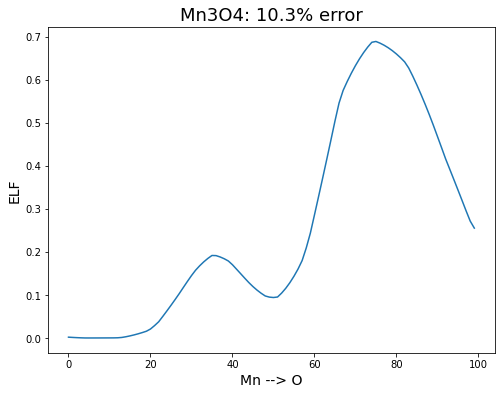

In [91]:
# Mn3O4
'''
Bond: l(Mn3-O6) =  1.92872(0) Å
   3     Mn3 Mn  0.50000  0.50000  0.50000 ( 0, 0, 0)+ x, y, z
  12      O6  O  0.73088  0.48581  0.75803 ( 0, 0, 0)+ x, y, z
'''
mn3o4_bond = new_dict['Mn3O4'].linear_slice([0.50000,  0.50000,  0.50000], [0.73088,  0.48581,  0.75803])
bond_dict['Mn3O4'] = mn3o4_bond
plt.plot(mn3o4_bond)
plt.title('Mn3O4: 10.3% error', fontsize=18)
plt.xlabel('Mn --> O', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/Mn3O4', dpi=300)
plt.show()

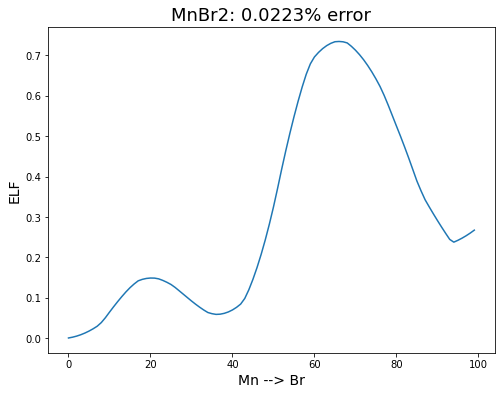

In [92]:
# MnBr2
'''
Bond: l(Mn1-Br2) =  2.68813(0) Å
   1     Mn1 Mn  1.00000  0.00000  1.00000 ( 1, 0, 1)+ x, y, z
   3     Br2 Br  0.66667  0.33333  0.76781 ( 0, 0, 0)+ x, y, z
'''
mnbr2_bond = new_dict['MnBr2'].linear_slice([1.00000,  0.00000,  1.00000], [0.66667,  0.33333,  0.76781])
bond_dict['MnBr2'] = mnbr2_bond
plt.plot(mnbr2_bond)
plt.title('MnBr2: 0.0223% error', fontsize=18)
plt.xlabel('Mn --> Br', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/MnBr2', dpi=300)
plt.show()

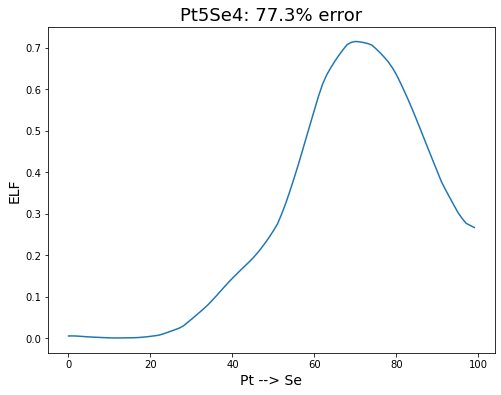

In [94]:
# Pt5Se4
'''
Atom: 17   Se7  Se   0.96012   0.51472   0.14428  ( 0, 0, 0)+ x, y, z
          (x,y,z):   0.00000   0.00000   0.00000
              Occ. = 1.000           B = 1.00000      1a       1
Atom:  7   Pt7  Pt   0.66202   0.22253   0.17265  ( 0, 0, 0)+ x, y, z
          (x,y,z):   0.00000   0.00000   0.00000
              Occ. = 1.000           B = 1.00000      1a       1
'''
pt5se4_notbond = new_dict['Pt5Se4'].linear_slice([0.66202,   0.22253,   0.17265], [0.96012,   0.51472,   0.14428])
bond_dict['Pt5Se4'] = pt5se4_notbond
plt.plot(pt5se4_notbond)
plt.title('Pt5Se4: 77.3% error', fontsize=18)
plt.xlabel('Pt --> Se', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/Pt5Se4', dpi=300)
plt.show()

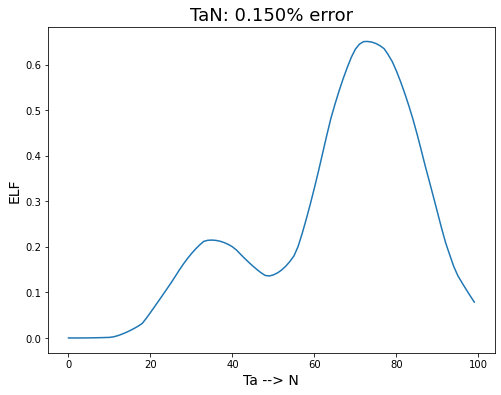

In [95]:
# TaN
'''
Bond: l(Ta2-N2) =  2.15750(0) Å
   2     Ta2 Ta  0.33333  0.66667  0.50000 ( 0, 0, 0)+ x, y, z
   5      N2  N  0.60833  0.60833  1.00000 ( 0, 0, 1)+ x, y, z
'''
tan_bond = new_dict['TaN'].linear_slice([0.33333,  0.66667,  0.50000], [0.60833,  0.60833,  1.00000])
bond_dict['TaN'] = tan_bond
plt.plot(tan_bond)
plt.title('TaN: 0.150% error', fontsize=18)
plt.xlabel('Ta --> N', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/TaN', dpi=300)
plt.show()

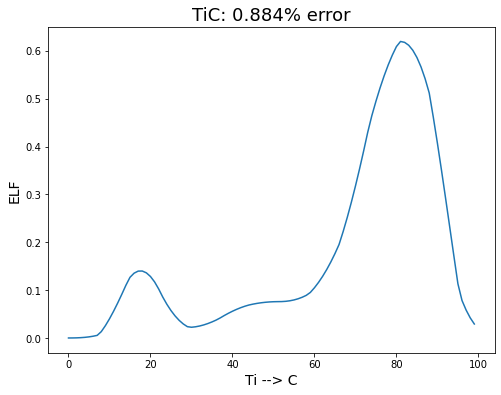

In [96]:
# TiC
'''
Atom:  1   Ti1  Ti   0.00000   0.00000   0.00000  ( 0, 0, 0)+ x, y, z
          (x,y,z):   0.00000   0.00000   0.00000
              Occ. = 1.000           B = 1.00000      1a       1
Atom:  2    C1   C   0.50000   0.50000   0.50000  ( 0, 0, 0)+ x, y, z
          (x,y,z):   0.00000   0.00000   0.00000
              Occ. = 1.000           B = 1.00000      1a       1
'''
tic_notbond = new_dict['TiC'].linear_slice([0.00000,   0.00000,   0.00000], [0.50000,   0.50000,   0.50000])
bond_dict['TiC'] = tic_notbond
plt.plot(tic_notbond)
plt.title('TiC: 0.884% error', fontsize=18)
plt.xlabel('Ti --> C', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/TiC', dpi=300)
plt.show()

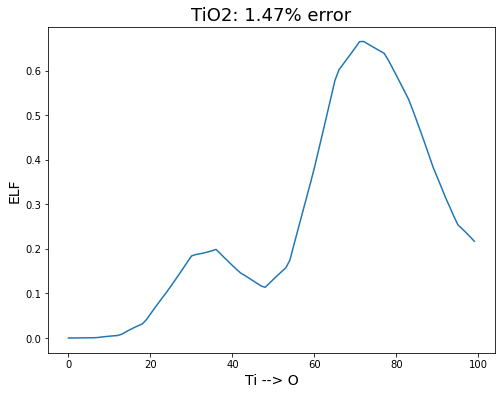

In [97]:
# TiO2
'''
Bond: l(Ti2-O4) =  1.93263(0) Å
   2     Ti2 Ti  0.12500  0.37500  0.75000 ( 0, 0, 0)+ x, y, z
   6      O4  O  0.66795  0.41795  0.83589 ( 0, 0, 0)+ x, y, z
'''
tio2_bond = new_dict['TiO2'].linear_slice([0.12500,  0.37500,  0.75000], [0.66795,  0.41795,  0.83589])
bond_dict['TiO2'] = tio2_bond
plt.plot(tio2_bond)
plt.title('TiO2: 1.47% error', fontsize=18)
plt.xlabel('Ti --> O', fontsize=14)
plt.ylabel('ELF', fontsize=14)
#plt.savefig('linear_bond_plots/TiO2', dpi=300)
plt.show()

In [101]:
skewness_dict = {}
for f in bond_dict.keys():
    skewness_dict[f] = skew(bond_dict[f])
skewness_dict

{'Al2S3': -0.17671808518491378,
 'Eu2O3': -0.46991883303716686,
 'Fe2O3': 0.80039965056374,
 'IrO2': 0.5564727479372498,
 'K2Si4O9-KO': -0.15456133865953908,
 'K2Si4O9-SiO': -0.036618751587753386,
 'MgSO4-MgO': 0.467208402060091,
 'MgSO4-SO': 0.12759958910223648,
 'Mn3O4': 0.5858099991201223,
 'MnBr2': 0.555933374779999,
 'Pt5Se4': 0.36686032533100343,
 'TaN': 0.731012651833614,
 'TiC': 1.247107544320838,
 'TiO2': 0.579877504736411}

In [104]:
f = loadfn('elf_error_data.json')
error_data = pd.read_json(f)
error_dict = {}
for index, row in error_data.iterrows():
    error_dict[row.Formula] = abs(row['Percent Error'])
error_dict

{'Fe2O3': 0.0371797693,
 'MnBr2': 0.0002225226,
 'TiO2': 0.0147037895,
 'TiC': 0.0088350571,
 'Mn3O4': 0.10309390830000001,
 'K2Si4O9': 0.0358187354,
 'TaN': 0.0014971885000000002,
 'Al2S3': 0.1671070963,
 'MgSO4': 0.0010884476,
 'Eu2O3': 0.1297942128,
 'Pt5Se4': 0.7730430734,
 'IrO2': 0.0001941447}

In [128]:
skewlist, errlist, flist = list(), list(), list()
for f in skewness_dict.keys():
    #if not f in ['Pt5Se4', 'K2Si4O9-SiO', 'MgSO4-SO']:
        flist.append(f)
        skewlist.append(skewness_dict[f])
        errlist.append(error_dict[f.split('-', 1)[0]])

In [129]:
fig = go.Figure(data=go.Scatter(x=skewlist,
                                y=errlist,
                                mode='markers',
                                text=flist))
fig.show()